## Model building - Impute Target Campaign

Import all the required libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
import imblearn
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

In [274]:
import warnings
warnings.filterwarnings('ignore')

In [275]:
pd.set_option('display.max_rows', 35000)
pd.set_option('display.max_columns', 35000)

Load dataset

In [276]:
campaign_df = pd.read_csv('campaign.csv')
campaign_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [277]:
campaign_df.shape

(32060, 16)

In [278]:
campaign_df.describe()

,participant_id,age,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance
count,3.206000e+04,32060.000000,32060.000000,32060.000000,32060.000000,32060.000000,32060.000000
mean,4.973681e+12,38.564816,7.757673,13.207611,5.290331,5.170930,0.424891
std,2.883537e+12,13.637532,3.859709,3.353797,2.673795,2.550475,0.494334
min,8.859368e+07,17.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.493678e+12,28.000000,5.000000,12.000000,3.000000,3.000000,0.000000
50%,4.962955e+12,37.000000,8.000000,13.000000,5.000000,5.000000,0.000000
75%,7.470135e+12,48.000000,10.000000,16.000000,8.000000,7.000000,1.000000
max,9.999820e+12,90.000000,20.000000,21.000000,10.000000,10.000000,1.000000


In [279]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32060 entries, 0 to 32059
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   participant_id        32060 non-null  float64
 1   name_title            19859 non-null  object 
 2   first_name            32060 non-null  object 
 3   last_name             32060 non-null  object 
 4   age                   32060 non-null  int64  
 5   postcode              32060 non-null  object 
 6   marital_status        32060 non-null  object 
 7   education             32060 non-null  object 
 8   job_title             32060 non-null  object 
 9   occupation_level      32060 non-null  int64  
 10  education_num         32060 non-null  int64  
 11  familiarity_FB        32060 non-null  int64  
 12  view_FB               32060 non-null  int64  
 13  interested_insurance  32060 non-null  int64  
 14  company_email         32060 non-null  object 
 15  created_account    

Check for missing values

In [280]:
campaign_df.isnull().sum()

participant_id              0
name_title              12201
first_name                  0
last_name                   0
age                         0
postcode                    0
marital_status              0
education                   0
job_title                   0
occupation_level            0
education_num               0
familiarity_FB              0
view_FB                     0
interested_insurance        0
company_email               0
created_account         29033
dtype: int64

In [281]:
campaign_df['created_account'].value_counts(normalize=True)*100

No     92.071358
Yes     7.928642
Name: created_account, dtype: float64

Filter available target columns only

In [282]:
available_df = campaign_df[campaign_df['created_account'].notnull()]
available_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [283]:
available_df_backup = available_df.copy()

In [284]:
available_df.shape

(3027, 16)

Drop un important columns

In [285]:
available_df.drop(['participant_id','name_title','first_name','last_name','company_email'],axis=1,inplace = True)
available_df.head()

,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account
0,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,No
1,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,No
2,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,No
3,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,No
4,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,No


In [286]:
available_df['created_account'].isnull().sum()

0

One hot encode age

In [287]:
available_df['age_by_decade'] = pd.cut(x=available_df['age'], bins=[10, 20, 29, 39, 49, 59, 69, 79, 89, 100], labels=['teens','20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])
available_df['age_by_decade'].value_counts()

30s      788
40s      711
20s      646
50s      413
teens    223
60s      187
70s       49
90s        5
80s        5
Name: age_by_decade, dtype: int64

In [288]:
ohe = OneHotEncoder(sparse=False)
X = available_df['age_by_decade']
age_by_decade_df = pd.DataFrame(ohe.fit_transform(np.array(X).reshape(-1, 1)))
age_by_decade_df.columns = list(ohe.get_feature_names(['age_by_decade']))
age_by_decade_df.drop('age_by_decade_90s',axis =1, inplace=True)

In [289]:
available_df = pd.concat([available_df,age_by_decade_df],axis=1)
available_df.drop(['age','age_by_decade'],axis=1,inplace=True)
available_df.head()

,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens
0,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [290]:
#tenc=ce.TargetEncoder() 
#df_postcode=tenc.fit_transform(available_df['postcode'],available_df['created_account'])
#available_df = df_postcode.join(available_df.drop('postcode',axis = 1))

Label encode postcode

In [291]:
postcode_list = available_df['postcode'].tolist()

In [292]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(postcode_list)
available_df['postcode_encoded'] = pd.DataFrame(le.transform(postcode_list))

In [293]:
available_df.drop('postcode',axis=1,inplace= True)
available_df.head(5)

,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded
0,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,913
1,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2155
2,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1760
3,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543
4,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2518


One hot encode marital_status

In [294]:
available_df['marital_status'].value_counts()

Married-civ-spouse       1379
Never-married             992
Divorced                  415
Widowed                   103
Separated                  92
Married-spouse-absent      43
Married-AF-spouse           3
Name: marital_status, dtype: int64

In [295]:
ohe = OneHotEncoder(sparse=False)
X = available_df['marital_status']
marital_status_df = pd.DataFrame(ohe.fit_transform(np.array(X).reshape(-1, 1)))
marital_status_df.columns = ['marital_status_divorced','marital_status_married-AF-spouse','marital_status_married-civ-spouse','marital_status_married-spouse-absent','marital_status_never-married','marital_status_separated','marital_status_widowed']
marital_status_df.drop('marital_status_married-AF-spouse',axis =1, inplace=True)

In [296]:
available_df = pd.concat([available_df,marital_status_df],axis=1)
available_df.drop('marital_status',axis=1,inplace=True)
available_df.head(5)

,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed
0,Bachelors,Furniture conservator/restorer,1,17,7,9,0,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,913,0.0,0.0,0.0,1.0,0.0,0.0
1,Bachelors,"Administrator, sports",4,17,9,6,1,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2155,0.0,1.0,0.0,0.0,0.0,0.0
2,HS-grad,Armed forces training and education officer,12,12,5,4,1,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1760,1.0,0.0,0.0,0.0,0.0,0.0
3,11th,Facilities assistant,1,9,9,2,0,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543,0.0,1.0,0.0,0.0,0.0,0.0
4,Bachelors,Information systems manager,12,17,8,9,1,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2518,0.0,1.0,0.0,0.0,0.0,0.0


Ordinal encode education

In [297]:
available_df['education'].value_counts()

HS-grad         979
Some-college    663
Bachelors       508
Masters         171
11th            133
Assoc-voc       132
Assoc-acdm       93
10th             86
7th-8th          58
Prof-school      50
9th              46
Doctorate        32
12th             28
5th-6th          28
1st-4th          16
Preschool         4
Name: education, dtype: int64

In [298]:
oe = OrdinalEncoder(categories = [['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college','Bachelors','Masters','Assoc-voc','Assoc-acdm','Prof-school','Doctorate']])
X = available_df['education']
education_df = pd.DataFrame(oe.fit_transform(np.array(X).reshape(-1,1)))
education_df.columns = ['education_encoded']

In [299]:
available_df = pd.concat([available_df,education_df],axis=1)
available_df.drop('education',axis=1,inplace = True)
available_df.head()

,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded
0,Furniture conservator/restorer,1,17,7,9,0,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,913,0.0,0.0,0.0,1.0,0.0,0.0,10.0
1,"Administrator, sports",4,17,9,6,1,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2155,0.0,1.0,0.0,0.0,0.0,0.0,10.0
2,Armed forces training and education officer,12,12,5,4,1,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1760,1.0,0.0,0.0,0.0,0.0,0.0,8.0
3,Facilities assistant,1,9,9,2,0,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543,0.0,1.0,0.0,0.0,0.0,0.0,6.0
4,Information systems manager,12,17,8,9,1,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2518,0.0,1.0,0.0,0.0,0.0,0.0,10.0


In [300]:
available_df.shape

(3027, 23)

Label encode job_title

In [301]:
job_title_df = pd.DataFrame(available_df['job_title'].value_counts())
job_title_df.reset_index(inplace=True)
job_title_df.columns = ['job_title','count']
job_title_df.head(5)

,job_title,count
0,"Engineer, manufacturing",50
1,"Accountant, chartered",48
2,Environmental health practitioner,47
3,"Education officer, community",46
4,Amenity horticulturist,42


In [302]:
job_title = campaign_df['job_title'].tolist()

In [303]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(job_title)
available_df['job_title_encoded'] = pd.DataFrame(le.transform(job_title))

In [304]:
#tenc=ce.TargetEncoder() 
#df_job_title=tenc.fit_transform(available_df['job_title'],available_df['created_account'])
#available_df = df_job_title.join(available_df.drop('job_title',axis = 1))
#available_df.head()

In [305]:
available_df.drop('job_title',axis=1,inplace= True)
available_df.head()

,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,job_title_encoded
0,1,17,7,9,0,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,913,0.0,0.0,0.0,1.0,0.0,0.0,10.0,277
1,4,17,9,6,1,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2155,0.0,1.0,0.0,0.0,0.0,0.0,10.0,16
2,12,12,5,4,1,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1760,1.0,0.0,0.0,0.0,0.0,0.0,8.0,47
3,1,9,9,2,0,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543,0.0,1.0,0.0,0.0,0.0,0.0,6.0,250
4,12,17,8,9,1,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2518,0.0,1.0,0.0,0.0,0.0,0.0,10.0,340


Convert created_account to numeric

In [306]:
substitute = {'Yes' : 1, 'No' : 0}
available_df['created_account'] = available_df['created_account'].map(substitute)
available_df.head()

,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,job_title_encoded
0,1,17,7,9,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,913,0.0,0.0,0.0,1.0,0.0,0.0,10.0,277
1,4,17,9,6,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2155,0.0,1.0,0.0,0.0,0.0,0.0,10.0,16
2,12,12,5,4,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1760,1.0,0.0,0.0,0.0,0.0,0.0,8.0,47
3,1,9,9,2,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543,0.0,1.0,0.0,0.0,0.0,0.0,6.0,250
4,12,17,8,9,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2518,0.0,1.0,0.0,0.0,0.0,0.0,10.0,340


In [307]:
available_df['created_account'].value_counts()

0    2787
1     240
Name: created_account, dtype: int64

Filter columns required for scaling

In [308]:
available_df_scaled = available_df.copy()
available_df_scaled = available_df_scaled[['occupation_level','education_num','postcode_encoded','job_title_encoded']]
available_df_scaled.head()

,occupation_level,education_num,postcode_encoded,job_title_encoded
0,1,17,913,277
1,4,17,2155,16
2,12,12,1760,47
3,1,9,543,250
4,12,17,2518,340


Apply StandardScaler

In [309]:
scaler = StandardScaler()
available_df_scaled = pd.DataFrame(scaler.fit_transform(available_df_scaled))
available_df_scaled.columns = ['occupation_level_scaled','education_num_scaled','postcode_encoded_scaled','job_title_encoded_scaled']
available_df_scaled.head()

,occupation_level_scaled,education_num_scaled,postcode_encoded_scaled,job_title_encoded_scaled
0,-1.740809,1.136871,-0.683464,0.156224
1,-0.962076,1.136871,0.741621,-1.343006
2,1.114546,-0.362610,0.288393,-1.164936
3,-1.740809,-1.262298,-1.108006,0.001131
4,1.114546,1.136871,1.158131,0.518107


In [310]:
available_df = pd.concat([available_df,available_df_scaled],axis=1)
available_df.drop(['occupation_level','education_num','postcode_encoded','job_title_encoded'],axis=1,inplace=True)
available_df.head()

,familiarity_FB,view_FB,interested_insurance,created_account,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,occupation_level_scaled,education_num_scaled,postcode_encoded_scaled,job_title_encoded_scaled
0,7,9,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,-1.740809,1.136871,-0.683464,0.156224
1,9,6,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,-0.962076,1.136871,0.741621,-1.343006
2,5,4,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,1.114546,-0.362610,0.288393,-1.164936
3,9,2,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,-1.740809,-1.262298,-1.108006,0.001131
4,8,9,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,1.114546,1.136871,1.158131,0.518107


In [311]:
available_df.to_csv('available_df.csv')

#### Model building

In [312]:
y = available_df.pop('created_account')
X = available_df

In [313]:
X_train, X_test, y_train, y_test = train_test_split(available_df,y, train_size=0.8,test_size=0.2,random_state=111)
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (2421, 22)
Training dataset target size (2421,)
Test dataset size (606, 22)
Test dataset target size (606,)


In [314]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(15, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

### Using SMOTE

In [315]:
# Random Over Sampling

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2421, 22)
Number transactions y_train dataset:  (2421,)
Number transactions X_test dataset:  (606, 22)
Number transactions y_test dataset:  (606,)


In [316]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))

Before OverSampling, counts of label '1': 182
Before OverSampling, counts of label '0': 2239 

After OverSampling, the shape of train_X: (4478, 22)
After OverSampling, the shape of train_y: (4478,) 

After OverSampling, counts of label '1': 2239
After OverSampling, counts of label '0': 2239


#### Logistic Regression

In [317]:
logistic_model = LogisticRegression()

# Default-Run of default-hyperparameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

logistic_model = model_selection.GridSearchCV(estimator=logistic_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)

logistic_model.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [318]:
best_params = logistic_model.best_params_
best_params['C']

1

In [319]:
logistic_model = LogisticRegression(C=best_params['C'])

logistic_model.fit(X_train_smote, y_train_smote)
predictions = logistic_model.predict(X_test)

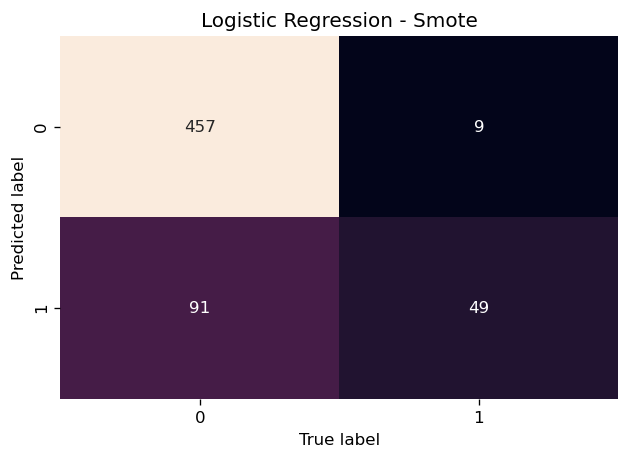

In [320]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=120)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Logistic Regression - Smote')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.savefig('Logistic Regression - Confusion Matrix - SMOTE')
#plt.show()

In [321]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       548
           1       0.35      0.84      0.49        58

    accuracy                           0.83       606
   macro avg       0.67      0.84      0.70       606
weighted avg       0.92      0.83      0.86       606



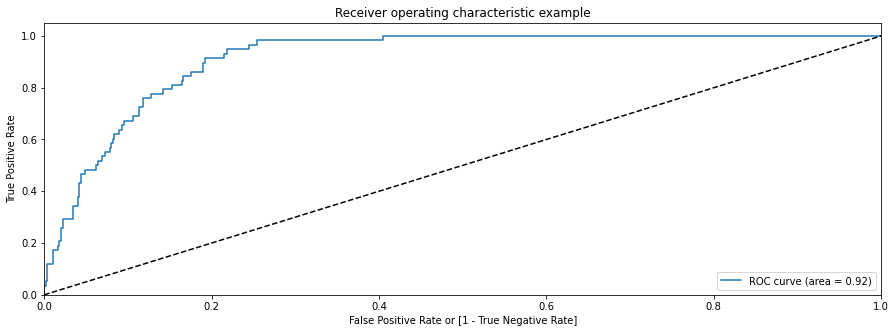

In [322]:
# Predicted probability
y_test_pred_proba = logistic_model.predict_proba(X_test)[:,1]

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

#### Random Forest

In [323]:
#Number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

#Number of features to consider at every split:
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree:
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

#Minimum number of samples required to split a node :
min_samples_split = [2, 5, 10, 15, 100]

#Minimum number of samples required at each leaf node :
min_samples_leaf = [1, 2, 5, 10]

In [324]:
#Setting the random grid :
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [325]:
random_forests = RandomForestClassifier()

random_forests_random = RandomizedSearchCV(estimator = random_forests, param_distributions = param_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1)

In [326]:
random_forests_random.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [327]:
random_forests_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [328]:
random_forests = RandomForestClassifier( n_estimators = 1000,
                                         min_samples_split = 2,
                                         min_samples_leaf = 1,
                                         max_features = 'sqrt',
                                         max_depth = 25,
                                         random_state = 101)

In [329]:
random_forests = random_forests.fit(X_train_smote,y_train_smote)
predictions=random_forests.predict(X_test)

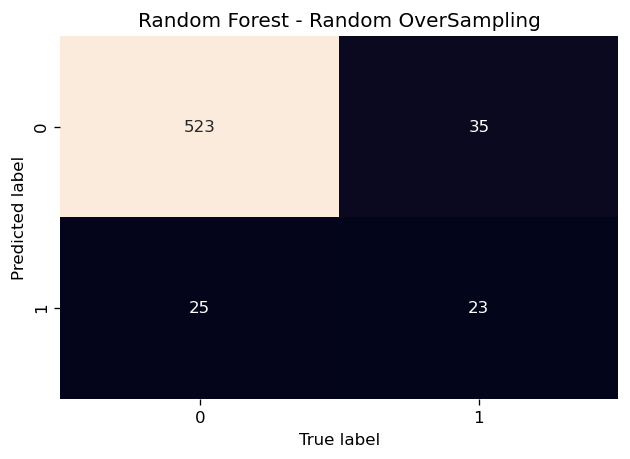

In [330]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=120)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Random Forest - Random OverSampling')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [331]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       548
           1       0.48      0.40      0.43        58

    accuracy                           0.90       606
   macro avg       0.71      0.68      0.69       606
weighted avg       0.89      0.90      0.90       606



In [332]:
importances = random_forests.feature_importances_
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
sorted_feature_importance

,colName,value
0,0.238766,postcode_encoded_scaled
1,0.164645,occupation_level_scaled
2,0.130643,marital_status_married-civ-spouse
3,0.075964,education_num_scaled
4,0.067439,education_encoded
5,0.050745,job_title_encoded_scaled
6,0.044114,marital_status_never-married
7,0.041383,age_by_decade_40s
8,0.038818,view_FB
9,0.032342,familiarity_FB


In [334]:
import pickle
with open("random_forests", "wb") as f:
    pickle.dump(random_forests, f)

## Prediction : Target missing value imputation

In [335]:
campaign_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [336]:
campaign_df['marital_status'].value_counts()

Married-civ-spouse       14747
Never-married            10531
Divorced                  4365
Separated                 1007
Widowed                    976
Married-spouse-absent      411
Married-AF-spouse           23
Name: marital_status, dtype: int64

In [337]:
target_df = campaign_df[campaign_df['created_account'].isnull()]
target_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
3027,4.520190e+12,Mr.,Jonathan,Cox,42,L56 9GD,Married-civ-spouse,Prof-school,Director,17,20,4,5,1,chloe49@williams.com,NaN
3028,8.025370e+12,NaN,Denis,Dodd,22,EH42 7LW,Never-married,Some-college,"Engineer, land",3,13,9,7,0,awilliams@smart.net,NaN
3029,6.935130e+12,Dr.,Michael,Lowe,28,SN3 6PL,Married-civ-spouse,Masters,Insurance account manager,12,18,3,6,0,mark00@murray.com,NaN
3030,4.571560e+12,Miss,Nigel,Pearce,60,EH8E 5EG,Widowed,HS-grad,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,NaN
3031,5.894380e+12,Miss,Shane,Graham,31,EH2V 8FS,Separated,HS-grad,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,NaN


In [338]:
target_df['marital_status'].value_counts()

Married-civ-spouse       13368
Never-married             9539
Divorced                  3950
Separated                  915
Widowed                    873
Married-spouse-absent      368
Married-AF-spouse           20
Name: marital_status, dtype: int64

In [339]:
target_df_copy = target_df.copy()

In [340]:
target_df.shape

(29033, 16)

In [341]:
target_df['age_by_decade'] = pd.cut(x=target_df['age'], bins=[10, 20, 29, 39, 49, 59, 69, 79, 89, 100], labels=['teens','20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])
target_df['age_by_decade'].value_counts()

30s      7691
20s      6554
40s      6346
50s      3930
teens    2159
60s      1794
70s       453
80s        70
90s        36
Name: age_by_decade, dtype: int64

In [342]:
ohe = OneHotEncoder(sparse=False)
X = target_df['age_by_decade']
age_by_decade_df = pd.DataFrame(ohe.fit_transform(np.array(X).reshape(-1, 1)))
age_by_decade_df.columns = list(ohe.get_feature_names(['age_by_decade']))
age_by_decade_df.drop('age_by_decade_90s',axis =1, inplace=True)

In [343]:
age_by_decade_df.head()

,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
target_df = pd.concat([target_df.reset_index(drop=True),age_by_decade_df.reset_index(drop=True)], axis=1)
target_df.shape

(29033, 25)

In [345]:
target_df.drop('age',axis=1,inplace=True)
target_df.head()

,participant_id,name_title,first_name,last_name,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens
0,4.520190e+12,Mr.,Jonathan,Cox,L56 9GD,Married-civ-spouse,Prof-school,Director,17,20,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,8.025370e+12,NaN,Denis,Dodd,EH42 7LW,Never-married,Some-college,"Engineer, land",3,13,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.935130e+12,Dr.,Michael,Lowe,SN3 6PL,Married-civ-spouse,Masters,Insurance account manager,12,18,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.571560e+12,Miss,Nigel,Pearce,EH8E 5EG,Widowed,HS-grad,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5.894380e+12,Miss,Shane,Graham,EH2V 8FS,Separated,HS-grad,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [346]:
target_df.tail()

,participant_id,name_title,first_name,last_name,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens
29028,9.368440e+12,NaN,Trevor,Rowe,EH11 9AD,Never-married,HS-grad,"Designer, ceramics/pottery",4,12,7,4,1,jemma98@kennedy-bell.com,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29029,4.452980e+12,Mrs.,Benjamin,Williams,EH73 3RY,Divorced,12th,Best boy,3,10,8,7,1,williamsbenjamin@ward.net,NaN,50s,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29030,1.017390e+12,Mr.,Frank,Saunders,SN94 0DX,Married-civ-spouse,Bachelors,Environmental health practitioner,6,17,3,4,1,glenn44@wyatt-ryan.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29031,1.089440e+12,NaN,Raymond,Dunn,EH95 7NN,Widowed,Some-college,Event organiser,6,13,6,2,1,oliver79@young.info,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29032,2.740440e+12,Mr.,Aaron,Edwards,SN3N 0BU,Married-civ-spouse,Some-college,Microbiologist,8,13,7,5,1,jacob22@ingram.com,NaN,50s,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [347]:
postcode_list = target_df['postcode'].tolist()

In [348]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(postcode_list)
target_df['postcode_encoded'] = pd.DataFrame(le.transform(postcode_list))
target_df.shape

(29033, 25)

In [349]:
target_df.drop('postcode',axis=1,inplace= True)
target_df.head(5)

,participant_id,name_title,first_name,last_name,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded
0,4.520190e+12,Mr.,Jonathan,Cox,Married-civ-spouse,Prof-school,Director,17,20,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19083
1,8.025370e+12,NaN,Denis,Dodd,Never-married,Some-college,"Engineer, land",3,13,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9100
2,6.935130e+12,Dr.,Michael,Lowe,Married-civ-spouse,Masters,Insurance account manager,12,18,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24617
3,4.571560e+12,Miss,Nigel,Pearce,Widowed,HS-grad,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16419
4,5.894380e+12,Miss,Shane,Graham,Separated,HS-grad,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6594


In [350]:
ohe = OneHotEncoder(sparse=False)
X = target_df['marital_status']
marital_status_df = pd.DataFrame(ohe.fit_transform(np.array(X).reshape(-1, 1)))
marital_status_df.columns = ['marital_status_divorced','marital_status_married-AF-spouse','marital_status_married-civ-spouse','marital_status_married-spouse-absent','marital_status_never-married','marital_status_separated','marital_status_widowed']
marital_status_df.drop('marital_status_married-AF-spouse',axis =1, inplace=True)

In [351]:
pd.DataFrame(ohe.fit_transform(np.array(X).reshape(-1, 1))).head()

,0,1,2,3,4,5,6
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [352]:
target_df = pd.concat([target_df,marital_status_df],axis=1)
target_df.drop('marital_status',axis=1,inplace=True)
target_df.head()

,participant_id,name_title,first_name,last_name,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed
0,4.520190e+12,Mr.,Jonathan,Cox,Prof-school,Director,17,20,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19083,0.0,1.0,0.0,0.0,0.0,0.0
1,8.025370e+12,NaN,Denis,Dodd,Some-college,"Engineer, land",3,13,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9100,0.0,0.0,0.0,1.0,0.0,0.0
2,6.935130e+12,Dr.,Michael,Lowe,Masters,Insurance account manager,12,18,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24617,0.0,1.0,0.0,0.0,0.0,0.0
3,4.571560e+12,Miss,Nigel,Pearce,HS-grad,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16419,0.0,0.0,0.0,0.0,0.0,1.0
4,5.894380e+12,Miss,Shane,Graham,HS-grad,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6594,0.0,0.0,0.0,0.0,1.0,0.0


In [353]:
target_df.shape

(29033, 29)

In [354]:
oe = OrdinalEncoder(categories = [['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college','Bachelors','Masters','Assoc-voc','Assoc-acdm','Prof-school','Doctorate']])
X = target_df['education']
education_df = pd.DataFrame(oe.fit_transform(np.array(X).reshape(-1,1)))
education_df.columns = ['education_encoded']

In [355]:
target_df = pd.concat([target_df,education_df],axis=1)
target_df.drop('education',axis=1,inplace = True)
target_df.head()

,participant_id,name_title,first_name,last_name,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded
0,4.520190e+12,Mr.,Jonathan,Cox,Director,17,20,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19083,0.0,1.0,0.0,0.0,0.0,0.0,14.0
1,8.025370e+12,NaN,Denis,Dodd,"Engineer, land",3,13,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9100,0.0,0.0,0.0,1.0,0.0,0.0,9.0
2,6.935130e+12,Dr.,Michael,Lowe,Insurance account manager,12,18,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24617,0.0,1.0,0.0,0.0,0.0,0.0,11.0
3,4.571560e+12,Miss,Nigel,Pearce,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16419,0.0,0.0,0.0,0.0,0.0,1.0,8.0
4,5.894380e+12,Miss,Shane,Graham,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6594,0.0,0.0,0.0,0.0,1.0,0.0,8.0


In [356]:
target_df.shape

(29033, 29)

In [357]:
#job_title = campaign_df['job_title'].tolist()

In [358]:
job_title_df = pd.DataFrame(target_df['job_title'].value_counts())
job_title_df.reset_index(inplace=True)
job_title_df.columns = ['job_title','count']
job_title_df.head(5)

,job_title,count
0,"Accountant, chartered",436
1,"Engineer, manufacturing",431
2,Tutor,422
3,Amenity horticulturist,420
4,"Education officer, community",397


In [359]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(job_title)
target_df['job_title_encoded'] = pd.DataFrame(le.transform(job_title))

In [360]:
target_df.drop('job_title',axis=1,inplace= True)
target_df.head()

,participant_id,name_title,first_name,last_name,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,postcode_encoded,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,job_title_encoded
0,4.520190e+12,Mr.,Jonathan,Cox,17,20,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19083,0.0,1.0,0.0,0.0,0.0,0.0,14.0,277
1,8.025370e+12,NaN,Denis,Dodd,3,13,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9100,0.0,0.0,0.0,1.0,0.0,0.0,9.0,16
2,6.935130e+12,Dr.,Michael,Lowe,12,18,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24617,0.0,1.0,0.0,0.0,0.0,0.0,11.0,47
3,4.571560e+12,Miss,Nigel,Pearce,3,12,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16419,0.0,0.0,0.0,0.0,0.0,1.0,8.0,250
4,5.894380e+12,Miss,Shane,Graham,6,12,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6594,0.0,0.0,0.0,0.0,1.0,0.0,8.0,340


In [361]:
target_df.shape

(29033, 29)

In [362]:
target_df_scaled = target_df.copy()
target_df_scaled = target_df_scaled[['occupation_level','education_num','postcode_encoded','job_title_encoded']]
target_df_scaled.head()

,occupation_level,education_num,postcode_encoded,job_title_encoded
0,17,20,19083,277
1,3,13,9100,16
2,12,18,24617,47
3,3,12,16419,250
4,6,12,6594,340


In [363]:
#scaler = StandardScaler()
target_df_scaled = pd.DataFrame(scaler.transform(target_df_scaled))
target_df_scaled.columns = ['occupation_level_scaled','education_num_scaled','postcode_encoded_scaled','job_title_encoded_scaled']
target_df_scaled.head()

,occupation_level_scaled,education_num_scaled,postcode_encoded_scaled,job_title_encoded_scaled
0,2.412435,2.036559,20.165001,0.156224
1,-1.221653,-0.062714,8.710393,-1.343006
2,1.114546,1.436767,26.514775,-1.164936
3,-1.221653,-0.362610,17.108297,0.001131
4,-0.442920,-0.362610,5.834980,0.518107


In [364]:
target_df_scaled.shape

(29033, 4)

In [365]:
target_df.shape

(29033, 29)

In [366]:
target_df = pd.concat([target_df,target_df_scaled],axis=1)
target_df.drop(['occupation_level','education_num','postcode_encoded','job_title_encoded'],axis=1,inplace=True)
target_df.head()

,participant_id,name_title,first_name,last_name,familiarity_FB,view_FB,interested_insurance,company_email,created_account,age_by_decade,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,occupation_level_scaled,education_num_scaled,postcode_encoded_scaled,job_title_encoded_scaled
0,4.520190e+12,Mr.,Jonathan,Cox,4,5,1,chloe49@williams.com,NaN,40s,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.0,2.412435,2.036559,20.165001,0.156224
1,8.025370e+12,NaN,Denis,Dodd,9,7,0,awilliams@smart.net,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,-1.221653,-0.062714,8.710393,-1.343006
2,6.935130e+12,Dr.,Michael,Lowe,3,6,0,mark00@murray.com,NaN,20s,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.114546,1.436767,26.514775,-1.164936
3,4.571560e+12,Miss,Nigel,Pearce,7,2,0,xwilliams@hayes.com,NaN,60s,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,-1.221653,-0.362610,17.108297,0.001131
4,5.894380e+12,Miss,Shane,Graham,8,7,1,vanessa34@richardson.org,NaN,30s,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,-0.442920,-0.362610,5.834980,0.518107


In [367]:
target_df.drop(['participant_id','name_title','first_name','last_name','company_email','created_account','age_by_decade'],axis=1,inplace=True)
target_df.head()

,familiarity_FB,view_FB,interested_insurance,age_by_decade_20s,age_by_decade_30s,age_by_decade_40s,age_by_decade_50s,age_by_decade_60s,age_by_decade_70s,age_by_decade_80s,age_by_decade_teens,marital_status_divorced,marital_status_married-civ-spouse,marital_status_married-spouse-absent,marital_status_never-married,marital_status_separated,marital_status_widowed,education_encoded,occupation_level_scaled,education_num_scaled,postcode_encoded_scaled,job_title_encoded_scaled
0,4,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.0,2.412435,2.036559,20.165001,0.156224
1,9,7,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,-1.221653,-0.062714,8.710393,-1.343006
2,3,6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.114546,1.436767,26.514775,-1.164936
3,7,2,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,-1.221653,-0.362610,17.108297,0.001131
4,8,7,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,-0.442920,-0.362610,5.834980,0.518107


In [368]:
target_df.shape

(29033, 22)

In [369]:
predictions=pd.DataFrame(random_forests.predict(target_df))

In [370]:
predictions.columns = ['created_account']
predictions.head()

,created_account
0,0
1,0
2,0
3,0
4,0


In [371]:
predictions.value_counts()

created_account
0                  28939
1                     94
dtype: int64

In [372]:
substitute = {0:'No',1:'Yes'}
predictions['created_account'] = predictions['created_account'].map(substitute)
predictions['created_account'].value_counts()

No     28939
Yes       94
Name: created_account, dtype: int64

In [373]:
#final_preds = pd.concat([target_df_copy,predictions],axis=1)
target_df_copy.drop('created_account',inplace=True,axis=1)
final_preds = pd.concat([target_df_copy.reset_index(drop=True),predictions.reset_index(drop=True)], axis=1)
#final_preds.drop('created_account',axis=1,inplace=True)
#final_preds = final_preds.rename({0:'created_account'},axis=1)
final_preds.shape

(29033, 16)

In [374]:
final_preds.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,4.520190e+12,Mr.,Jonathan,Cox,42,L56 9GD,Married-civ-spouse,Prof-school,Director,17,20,4,5,1,chloe49@williams.com,No
1,8.025370e+12,NaN,Denis,Dodd,22,EH42 7LW,Never-married,Some-college,"Engineer, land",3,13,9,7,0,awilliams@smart.net,No
2,6.935130e+12,Dr.,Michael,Lowe,28,SN3 6PL,Married-civ-spouse,Masters,Insurance account manager,12,18,3,6,0,mark00@murray.com,No
3,4.571560e+12,Miss,Nigel,Pearce,60,EH8E 5EG,Widowed,HS-grad,"Engineer, control and instrumentation",3,12,7,2,0,xwilliams@hayes.com,No
4,5.894380e+12,Miss,Shane,Graham,31,EH2V 8FS,Separated,HS-grad,"Accountant, chartered",6,12,8,7,1,vanessa34@richardson.org,No


In [375]:
final_df = pd.concat([available_df_backup.reset_index(drop=True),final_preds.reset_index(drop=True)], axis=0)
final_df.shape

(32060, 16)

In [376]:
final_df.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No
